## ANLP Assignment 1: Sentiment Analysis
### Christopher Hamilton,  a1766121

In [51]:
import json
import os

import pandas as pd
import numpy as np

### 1. Reading dataset and initial pre-processing

In [52]:
def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            # Load each line of the JSON file as a dictionary
            data.append(json.loads(line))

    # Form a Pandas DataFrame from the dictionaries
    return pd.json_normalize(data)

# Load the training and test data
raw_train_df = read_json_to_df("hotel_reviews_train.json")
raw_test_df = read_json_to_df("hotel_reviews_test.json")

In [53]:
# Print out the initially loaded dataframes
raw_train_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,111418,1,"June 28, 2012",132971117,False,3.0,2.0,...,1.0,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,671150,3,"February 4, 2012",124104157,False,NaN,NaN,...,NaN,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,NaN,NaN


In [54]:
raw_test_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_cities,author.num_helpful_votes,author.num_reviews,author.num_type_reviews,author.id,author.location,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,November 2011,1783324,1,"November 26, 2011",121063682,False,5.0,5.0,...,5.0,shooflyfarm,15.0,12.0,30.0,11.0,02C39D355EE31BFA82F2724523782A92,"Opelika, Alabama",NaN,NaN
1,“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,August 2011,88458,0,"August 10, 2011",116545869,False,5.0,5.0,...,NaN,bestmpm,NaN,NaN,1.0,NaN,8F37B44FE89FD626313A7CB4B381FE40,Chattanooga,NaN,NaN
2,“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,November 2010,82868,0,"December 6, 2010",89196759,False,5.0,5.0,...,5.0,Conner2dood,20.0,39.0,26.0,24.0,5E57B2B21C69F07E617D67C748DF010A,Pennsylvania,NaN,NaN
3,“Unsung Hero”,"For the past year and a half, my daughter has ...",July 2011,98979,0,"July 28, 2011",115879719,False,5.0,5.0,...,NaN,LeviK,2.0,NaN,2.0,NaN,D7E5C22B3A877DEA1434B18E797FEE19,,NaN,NaN
4,"“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....",March 2007,112273,8,"March 21, 2007",7198417,False,5.0,5.0,...,5.0,thomrho,13.0,25.0,27.0,4.0,EEE6C615C8EBCA4AFD2774810E590274,"albuquerque, nm",5.0,5.0


In [55]:
# Select the title, text and overall rating columns to make a new dataframe
train_df = raw_train_df[["title", "text", "ratings.overall"]]
test_df = raw_test_df[["title", "text", "ratings.overall"]]

# Check the value counts for the ratings
print("Training data ratings")
print(train_df["ratings.overall"].value_counts())

print()

print("Test data ratings")
print(test_df["ratings.overall"].value_counts())

Training data ratings
ratings.overall
5.0    9825
4.0    7720
3.0    3287
2.0    1611
1.0    1557
Name: count, dtype: int64

Test data ratings
ratings.overall
5.0    2468
4.0    1933
3.0     793
2.0     420
1.0     385
0.0       1
Name: count, dtype: int64


In [56]:
# Find indices of rows where the rating is 0
zero_rating_indices = test_df[test_df['ratings.overall'] == 0].index
for index in zero_rating_indices:
    # Print the text corresponding to the zero rating
    print(test_df['text'][index])

Best location. Right where Pier 39 is. Lots of things to do around the area, restaurants and sight seeing. Staff are friendly. Great service. Will come back again :)


In [57]:
# Based on the above text, it is unlikely the reviewer meant to give a low rating
# Instead, we will remvoe the 0 from the dataset
test_df = test_df.drop(zero_rating_indices)

In [58]:
# Check the value counts for the ratings after the 0 rating has been removed
print("Test data ratings")
print(test_df["ratings.overall"].value_counts())

Test data ratings
ratings.overall
5.0    2468
4.0    1933
3.0     793
2.0     420
1.0     385
Name: count, dtype: int64


Python's lambda functions can be used to remove the special characters from the dataset. Pandas DataFrames columns include an `apply` method that can take in a lambda function to apply to each cell in the column. By including a lambda function that will only include characters which are alphanumeric or spaces, the special characters can be removed from the dataset (Saturn Cloud 2024).

At the same time, we can apply the `lower()` function on each character to convert all the text to lowercase. This can be seen by viewing the first few rows with the `head()` function on the DataFrames.

In [59]:
# Remove remove non-alphanumeric characters from the title and text columns
train_df.loc[:, 'title'] = train_df['title'].apply(lambda x: ''.join(char.lower() for char in x if char.isalnum() or char.isspace()))
train_df.loc[:, 'text'] = train_df['text'].apply(lambda x: ''.join(char.lower() for char in x if char.isalnum() or char.isspace()))

test_df.loc[:, 'title'] = test_df['title'].apply(lambda x: ''.join(char.lower() for char in x if char.isalnum() or char.isspace()))
test_df.loc[:, 'text'] = test_df['text'].apply(lambda x: ''.join(char.lower() for char in x if char.isalnum() or char.isspace()))

In [60]:
train_df.head()

,title,text,ratings.overall
0,horrible experience,first of all we got there and they didnt have ...,1.0
1,stay away,found racist graffiti in the room request to c...,1.0
2,great location and service,close to union square hotel is a bit of a maz...,4.0
3,i will never go back here again,i had a bad vibe about this place from the mom...,2.0
4,ripped off our visa card after departure,after we received our final bill and left the ...,1.0


In [61]:
test_df.head()

,title,text,ratings.overall
0,i was so surprised i will return,my husband and i just celebrated our 25th wedd...,5.0
1,a motherdaughter vacation,i could not leave a bad comment on any part of...,5.0
2,good choice for precruise,i spent one night at this hotel prior to a cru...,4.0
3,unsung hero,for the past year and a half my daughter has b...,5.0
4,great value for a king queen and princesses,great value for a king queen and princesses we...,5.0


The provided code for the `language_filter.py` file includes an example of using the `langdetect` Python package to filter for only English text. Rather than applying the filter for only English reviews when reading the file, we can apply the filter on the loaded DataFrames using a similar method to above. By using the Pandas `apply` method on the text and title columns, the returned DataFrame will only include rows where both the title and text are in English as determined by the `langdetect` package.

In [62]:
from langdetect import detect as detect_language

def filter_english_reviews(df):
    def is_english(text):
        try:
            return detect_language(text) == "en"
        except:
            return False

    # Filter the DataFrame for reviews where both title and text are in English
    return df[df['text'].apply(is_english) & df['title'].apply(is_english)]

Since the language detecting process takes some time over the whole dataset, to save time during development, the filtered DataFrames can be saved and loaded from CSV. Since these DataFrames will not change, and all preprocessing steps are the same, running the language filter each time is not necessary. I have written some quick checks to see if the files have already been saved, and if they have load them, otherwise run the language check code and save the files for later.

In [63]:
# Save the English reviews to a CSV file to save time filtering when running again (NumFOCUS, Inc. 2024)
if os.path.exists("english_hotel_reviews_train.csv"):
    train_df = pd.read_csv("english_hotel_reviews_train.csv")
else:
    train_df = filter_english_reviews(train_df)
    train_df.to_csv("english_hotel_reviews_train.csv", index=False)

if os.path.exists("english_hotel_reviews_test.csv"):
    test_df = pd.read_csv("english_hotel_reviews_test.csv")
else:
    test_df = filter_english_reviews(test_df)
    test_df.to_csv("english_hotel_reviews_test.csv", index=False)

In [64]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            18107 non-null  object 
 1   text             18107 non-null  object 
 2   ratings.overall  18107 non-null  float64
dtypes: float64(1), object(2)
memory usage: 424.5+ KB
None


In [65]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4524 entries, 0 to 4523
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4524 non-null   object 
 1   text             4524 non-null   object 
 2   ratings.overall  4524 non-null   float64
dtypes: float64(1), object(2)
memory usage: 106.2+ KB
None


### 2. Exploratory Data Analysis (EDA)

In [66]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

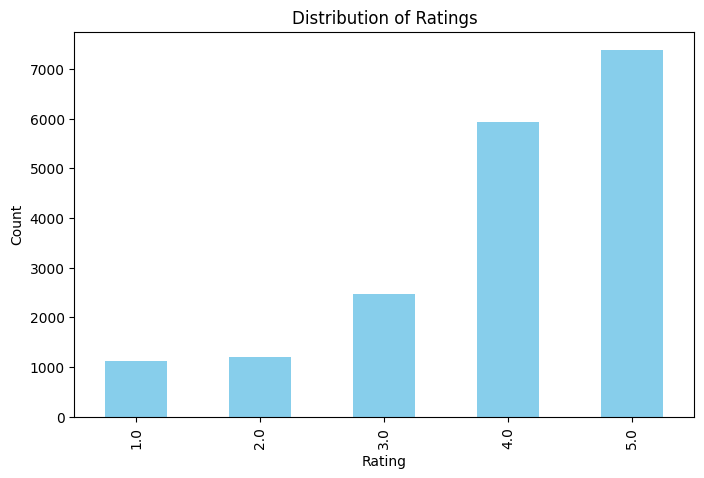

In [67]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

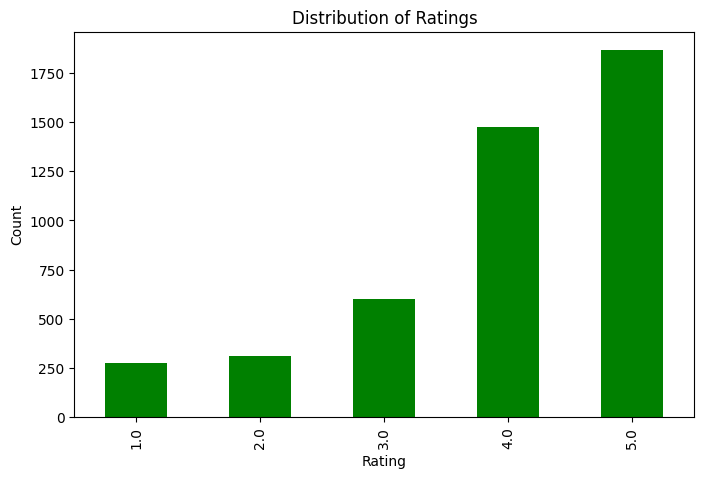

In [68]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
test_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='green')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

The distribution of the ratings can be plotted on a bar chart for both the training and test data. From the charts above, it is clear that most of the ratings for the hotels in the hotel booking company are positive, with a similar distribution of ratings across the training and testing sets.

Based on the code provided as part of Workshop 2, the predictive and non-predictive words in the dataset can be found using the TF-IDF (Term Frequency-Inverse Document Frequency) (Feature Engineering 2025). From TF-IDF, the words with the correlations closest to 0 indicate a very small effect on the prediction, whereas the words with a correlation higher indicate they are more positive and words with a more negative correlation indicate they are more negative.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tf_idf_train = vectorizer.fit_transform(train_df["text"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tf_idf_train.toarray(), columns=vectorizer.get_feature_names_out())

# Find the correlations with the ratings
correlations = tfidf_df.corrwith(train_df["ratings.overall"])
correlations = correlations.sort_values(ascending=False)

# Find 10 words with the weakest correlation by sorting
non_predictive_words = correlations.sort_values(key=lambda x: np.abs(x))
print("Non-Predictive Words:\n", non_predictive_words.head(10))

# Display top 10 positive and negative correlated words
print("Most Positive Words:\n", correlations.head(10))
print("\nMost Negative Words:\n", correlations.tail(10))

Non-Predictive Words:
 critisism     -3.630288e-07
grandma       -3.825844e-07
approaching   -7.587266e-07
campus        -9.823678e-07
whistles       9.995013e-07
multilevel    -2.720054e-06
sirius        -3.627844e-06
hospitably     3.745210e-06
format        -4.205995e-06
upload        -5.597163e-06
dtype: float64
Most Positive Words:
 great          0.245037
staff          0.191420
friendly       0.167738
comfortable    0.155392
and            0.154539
helpful        0.150268
wonderful      0.149302
perfect        0.143355
excellent      0.139939
very           0.133812
dtype: float64

Most Negative Words:
 terrible   -0.153617
they       -0.179330
said       -0.179603
rude       -0.186292
that       -0.200618
worst      -0.211617
dirty      -0.215988
no         -0.221317
told       -0.258012
not        -0.308856
dtype: float64


In order to find the number of unique words, the text can be converted into a list of tokens, and the number of unique tokens can then easily be found with `numpy`. Given that the data to be used for classification into the ratings is the textual review data, the title and text columns can be combined into a single text column. To make analysis simpler, the overall rating column can also be renamed to just rating. At this stage the stop words are also removed from the dataset.

In [70]:
from nltk.corpus import stopwords

# Create a column with the title and text together
train_df["combined_text"] = train_df["title"] + " " + train_df["text"]
test_df["combined_text"] = test_df["title"] + " " + test_df["text"]

train_df = train_df.drop(columns=["title", "text"])
test_df = test_df.drop(columns=["title", "text"])
train_df = train_df.rename(columns={"ratings.overall": "rating", "combined_text": "text"})
test_df = test_df.rename(columns={"ratings.overall": "rating", "combined_text": "text"})

stop_words = set(stopwords.words('english'))
train_df["text"] = train_df["text"].apply(lambda text: ' '.join([word for word in text.split(' ') if word not in stop_words]))
test_df["text"] = test_df["text"].apply(lambda text: ' '.join([word for word in text.split(' ') if word not in stop_words]))

# Split all reviews into words and find unique ones
all_words_text = np.concatenate(train_df.text.apply(nltk.word_tokenize).to_numpy())

unique_words = np.unique(all_words_text)

print("Total Unique Words:", len(unique_words))

Total Unique Words: 46531


In [71]:
train_df.head()

,rating,text
0,4.0,great location service close union square hot...
1,2.0,never go back bad vibe place moment walked mai...
2,1.0,ripped visa card departure received final bill...
3,4.0,great location steps grand central well situat...
4,3.0,location hotel located right heart san francis...


In [72]:
test_df.head()

,rating,text
0,5.0,surprised return husband celebrated 25th weddi...
1,5.0,motherdaughter vacation could leave bad commen...
2,4.0,good choice precruise spent one night hotel pr...
3,5.0,great value king queen princesses great value ...
4,5.0,learning lessons highend chains tremendous hot...


The most frequent words in the dataset can be plotted on a bar chart. Stop words are removed for this analysis so that the chart is not filled with very common words such as 'the' or 'is'.

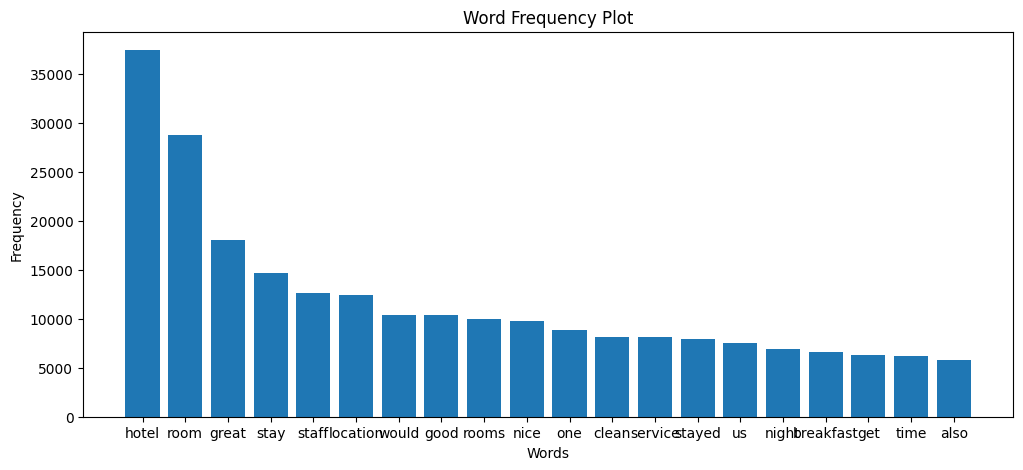

In [73]:
from collections import Counter
import matplotlib.pyplot as plt

tokens = [word for word in all_words_text if word not in stop_words]
word_freq = Counter(tokens)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*word_freq.most_common(20)))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Plot")
plt.show()


The most common trigrams in the dataset can give us insight into common phrases that are used in the dataset. (Exploratory Data Analysis 2025) These sequences can be calculated and listed as well as plotted on a chart for viewing.

Distribution of 3-grams:
within walking distance: 745
hotel great location: 675
front desk staff: 668
staff friendly helpful: 551
would definitely stay: 525
great place stay: 393
would recommend hotel: 282
empire state building: 274
flat screen tv: 266
would highly recommend: 254
stayed one night: 251
highly recommend hotel: 248
great location great: 238
new york city: 233
called front desk: 205
great hotel great: 199
right across street: 199
hotel good location: 189
recommend hotel anyone: 183
would definitely recommend: 168
easy walking distance: 152
great location stayed: 149
stayed 3 nights: 145
hotel staff friendly: 132
stay great location: 129
stayed two nights: 124
king size bed: 123
room clean comfortable: 121
walk times square: 121
stayed 4 nights: 120
home away home: 119
right next door: 116
good value money: 113
front desk clerk: 113
location location location: 112
made us feel: 112
really enjoyed stay: 109
stayed 2 nights: 109
friendly helpful staff: 108
nice hotel great: 1

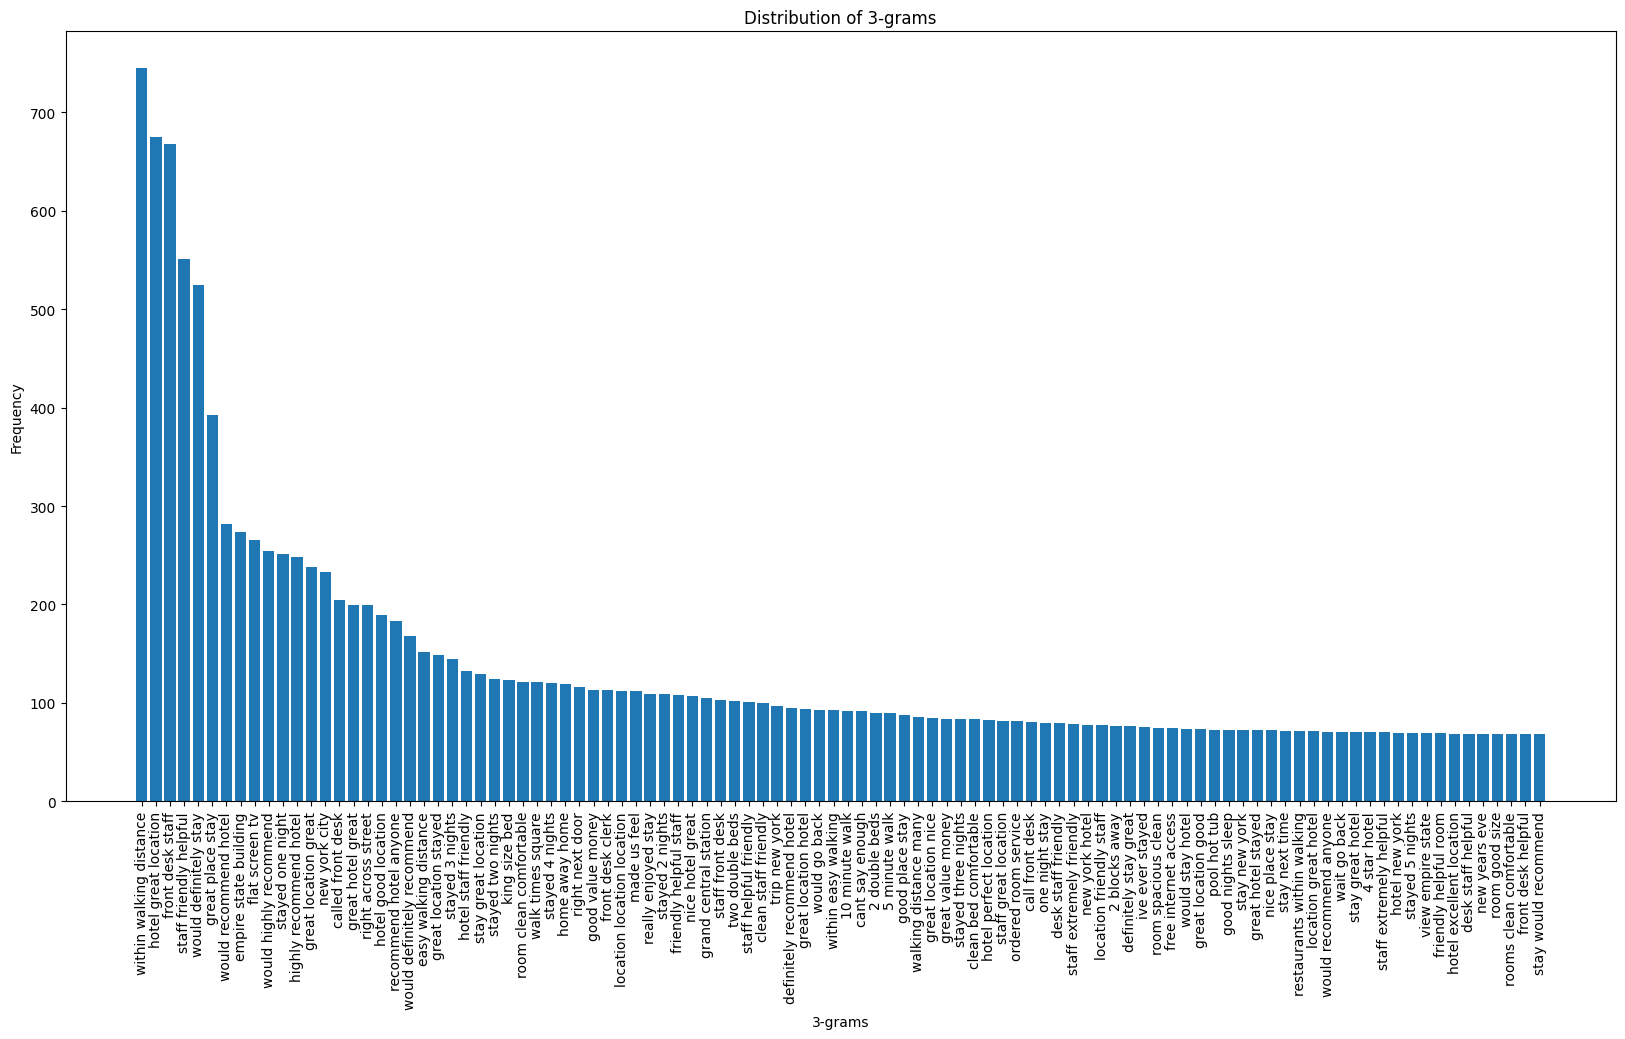

In [74]:
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)
most_common_ngrams = ngrams_count.most_common(100)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in most_common_ngrams:
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*most_common_ngrams)
indexes = range(len(labels))

plt.figure(figsize=(20, 10))
plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Selection and training Machine Learning models

When training machine learning models, the dataset should be balanced to ensure that there is no bias to any one category. In the training dataset, there are more positive reviews than negative, and as a result the trained model may become biased towards classifying text positively. To address this, it is possible to use oversampling to create a data set for training that includes an equal number for each category. (Income Evaluation Notebook 2025)

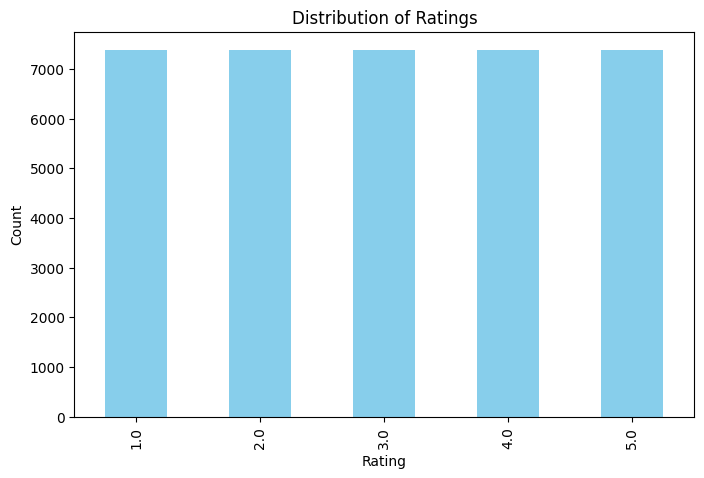

In [75]:
# Balance the training data by oversampling
def balance_data_oversample(df):
    max_count = df['rating'].value_counts().max()
    balanced_df = pd.DataFrame()

    for rating in df['rating'].unique():
        rating_df = df[df['rating'] == rating]
        balanced_df = pd.concat([balanced_df, rating_df.sample(max_count, replace=True)])

    return balanced_df
balanced_train_df = balance_data_oversample(train_df)

# Plot distribution of ratings
balanced_train_df['rating'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

The text is already in lowercase and stop words have been removed from the dataset. To prepare the data for machine learning, the text can be lemmatised. Lemmatisation is one method for reducing words to their base forms, and this can be included in the preprocessing of data before a machine learning technique is applied to improve results. (Murel 2023)

In [76]:
# Lemmatize the text
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
balanced_train_df.loc[:, 'text'] = balanced_train_df['text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))
test_df.loc[:, 'text'] = test_df['text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

[nltk_data] Downloading package wordnet to /home/dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The classical machine learning method that will be used in this experiment in Multinomial Naive Bayes. This classification algorithm "simplifies the process of classifying text by assuming that the presence of one word doesn’t depend on others", which "makes it computationally efficient and reliable for a range of tasks" (Sriram 2024). In order to train the Multinomial Naive Bayes classifier, the data must be arranged into a training and validation set.

The Scikit Learn Python module includes a function to automatically split a dataset into a training and testing set or a training an validation set. For the training that is to be completed in this experiment, 80% of the data will be used for training and 20% will be used for validation.

In [77]:
from sklearn.model_selection import train_test_split

X_res = balanced_train_df["text"]
y_res = balanced_train_df["rating"]

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, shuffle=True)

In [ ]:
# (Feature Engineering 2025)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)

In [79]:
from sklearn.model_selection import cross_val_score

#### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()

In [100]:
# (Income Evaluation Notebook 2025)
nb_accuracies = cross_val_score(classifier, X_train_vectors, y_train, cv=5)
classifier.fit(X_train_vectors, y_train)
print(f"Naive Bayes Train Score: {round(np.mean(nb_accuracies) * 100, 2)}%")

Naive Bayes Train Score: 78.48%


In [102]:
naive_bayes_score = classifier.score(X_val_vectors, y_val)
print(f"Naive Bayes Validation Score: {round(naive_bayes_score * 100, 2)}%")

Naive Bayes Validation Score: 79.15%


After training the Multinomial Naive Bayes classifier on the training data and testing the accuracy on the validation data, it is clear that the classification has performed quite well. The accuracy percentages are shown above, and this model could be considered to evaluate using the test data as well. However, a deep learning model should also be trained to determine how well it performs.

To do this, Tensorflow and Keras will be used. Some extra configuration is needed for Tensorflow to make use of the GPU, without encountering memory issues, as shown below.

In [83]:
import tensorflow as tf

# Limit GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=(6 * 1024))])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow.keras.utils import to_categorical

train_Y = balanced_train_df["rating"]
train_Y_cat = to_categorical(balanced_train_df["rating"]-1, num_classes=5)

test_Y = test_df["rating"]
test_Y_cat = to_categorical(test_df["rating"]-1, num_classes=5)

In [85]:
import requests
import zipfile

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

glove_dir = '../glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

# Download the GloVe file
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")

# Extract the GloVe file
if not os.path.exists(os.path.join(glove_dir, "glove.6B.100d.txt")):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_dir)
    print("Extraction complete.")

embedding_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()
print('Found %s word vectors ' % len(embedding_index))

Found 400000 word vectors 


In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer(oov_token="'oov'")
tokenizer.fit_on_texts(balanced_train_df['text'])

max_words = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [87]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 200
train_X = pad_sequences(tokenizer.texts_to_sequences(balanced_train_df['text']), maxlen=maxlen)
test_X = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=maxlen)

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

model=Sequential()
model.add(Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(8)))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
model.build(train_X.shape)
print(model.summary())

# Train the model
history = model.fit(
    train_X,
    train_Y,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (36890, 200, 100)      │     3,694,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (36890, 16)            │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (36890, 4)             │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (36890, 1)             │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,701,749 (14.12 MB)

 Trainable params: 7,049 (27.54 KB)

 Non-trainable params: 3,694,700 (14.09 MB)

None
Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7.8599 - val_loss: 23.5365
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.3210 - val_loss: 19.6251
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.4903 - val_loss: 15.4261
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.9554 - val_loss: 11.7011
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.9170 - val_loss: 8.3738
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3788 - val_loss: 6.7297
Epoch 7/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2897 - val_loss: 6.2937
Epoch 8/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2610 - val_loss: 6.2191
Epoch 9/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2496 - val_loss: 6.1747
Epoch 10/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2309 - val_loss: 6.1493
Epoch 11/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2206 - val_loss: 6.1387
Epoch 12/25
116/116 ━━━━━━━━━━━━

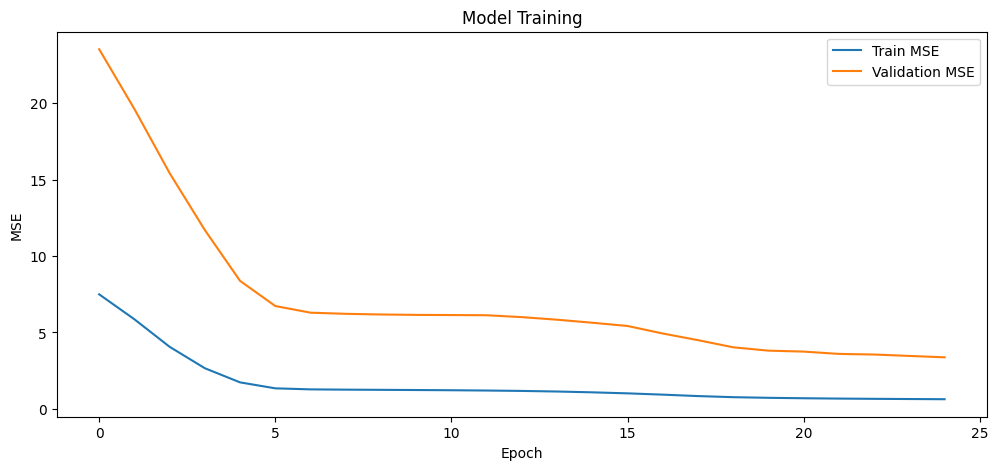

In [89]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training')
plt.legend()
plt.show()

### 4. Experiment with VADER sentiment lexicon

In [90]:
import numpy as np

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def include_sentiment_analysis(df):
    df2 = df.copy()
    # Create text data from text and title
    text_data = df2["text"].to_numpy()

    # Create target vector for VADER
    y = train_Y.apply(lambda x: "positive" if x > 3 else ("negative" if x < 3 else "neutral")).tolist()

    # Analyse with VADER
    analyser = SentimentIntensityAnalyzer()
    correct_predictions = 0

    for text in text_data:
        score = analyser.polarity_scores(text)
        sentiment = "neutral"
        # Classify the sentiment based on the compound score from the analyser
        if score['compound'] > 0.05:
            sentiment = "positive"
        elif score['compound'] < -0.05:
            sentiment = "negative"
        
        # Compare the predicted sentiment with the actual sentiment
        index = text_data.tolist().index(text)
        if sentiment == y[index]:
            correct_predictions += 1
            # Add the score to the balanced_train_df in a new column
            if index < len(df2):  # Ensure we are updating the correct row
                df2.loc[df2["text"] == text, "VADER_Sentiment"] = sentiment
        else:
            # Add the score based on the y value for sentiment
            if y[index] == "positive":
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "positive"
            elif y[index] == "negative":
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "negative"
            else:
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "neutral"

    return df2


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dev/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
balanced_train_df2 = include_sentiment_analysis(balanced_train_df)
train_X = pad_sequences(tokenizer.texts_to_sequences(balanced_train_df2['text']), maxlen=maxlen)
# Create a training set with the vader sentiment represented as -1 if neutral, 0 if negative and 1 if positive
train_X = np.concatenate((train_X, np.array(balanced_train_df2["VADER_Sentiment"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0)).tolist()).reshape(-1, 1)), axis=1)

In [92]:
# Train the model
history = model.fit(
    train_X,
    train_Y,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
)

Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.6342 - val_loss: 3.4323
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6108 - val_loss: 3.3128
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5959 - val_loss: 3.2472
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5837 - val_loss: 3.1113
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5727 - val_loss: 3.1012
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5715 - val_loss: 3.1427
Epoch 7/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5761 - val_loss: 3.0435
Epoch 8/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5577 - val_loss: 3.0169
Epoch 9/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5566 - val_loss: 2.9889
Epoch 10/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5475 - val_loss: 2.9454
Epoch 11/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5399 - val_loss: 2.9395
Epoch 12/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 

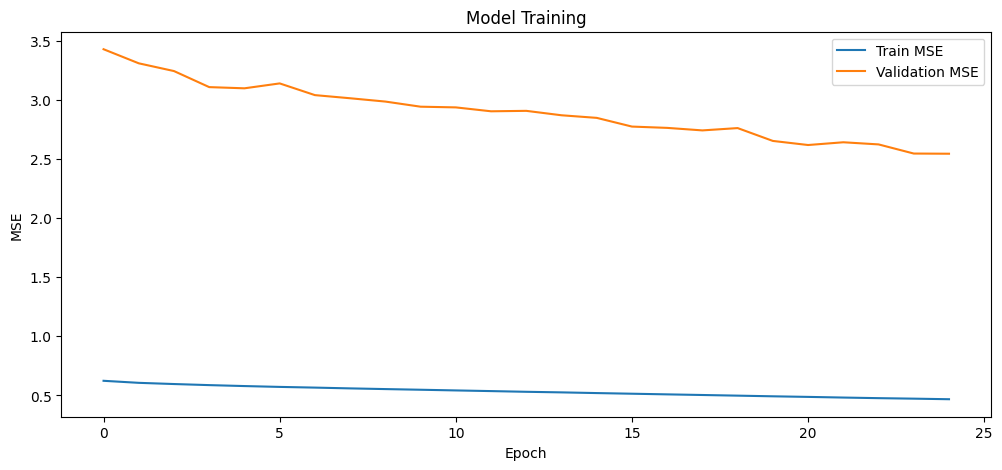

In [93]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training')
plt.legend()
plt.show()

### 5. Final testing on test set and discussion of results

In [94]:
# Predict the ratings for the test set and check the rating compared to the y_test_cat
predictions = model.predict(test_X)
# Compare the predictions with the actual ratings
predictions = np.round(predictions).astype(int)

# Calculate the mean squared error
mse = np.mean((predictions.flatten() - test_Y.to_numpy().flatten())**2)
print(f"Mean Squared Error: {mse:.2f}")

correct_predictions = np.sum(predictions.flatten() == test_Y.to_numpy().flatten())
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions
print(f"Model Accuracy: {accuracy:.2f}")


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 0.95
Model Accuracy: 0.35


In [95]:
# Show the predictions which were incorrect by more than 1
incorrect_predictions = np.abs(predictions.flatten() - test_Y.to_numpy().flatten()) > 1
incorrect_reviews = test_df[incorrect_predictions]
print("Incorrect Predictions:")
for i, row in incorrect_reviews.iterrows():
    print(f"Text: {row['text']}")
    print(f"Predicted Rating: {predictions[i][0]}")
    print(f"Actual Rating: {row['rating']}")
    print("-" * 50)

# Print the number of incorrect predictions compared to the total number of predictions
num_incorrect = len(incorrect_reviews)
num_total = len(test_df)
print(f"Total Predictions: {num_total}")
print(f"Number of Correct Predictions: {num_total - num_incorrect}")
print(f"Number of Incorrect Predictions: {num_incorrect}")
# Print the accuracy based on the number of correct predictions
accuracy = (num_total - num_incorrect) / num_total
print(f"Accuracy: {accuracy:.2f}")

Incorrect Predictions:
Text: motherdaughter vacation could leave bad comment part stay everyone nice room kept great shape u place clean
Predicted Rating: 2
Actual Rating: 5.0
--------------------------------------------------
Text: cant wait return london nyc absolutely overthetop experience beginning end least expensive spot town defy find hotel caliber offer suite size lower price wont since hotel freshly renovated every inch property spotless fresh london suite 17th floor silent window closed suite parlor separated bedroom small entryway welllit bathroom enormous huge mirror bathroom wall separated fabulous light panel made makeup application breeze addition shower area 9 x 4 rain shower type fixture one end shower massage fixture also euro handheld fixture base covered regarding showering option bed offered super deluxe pillowtop comfort pillow fab linen high threadcount sateen ambiance minimalistelegant suite throughout hotel didnt try restaurantbar loved every moment look forwar

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

'Exploratory Data Analysis', Applied Natural Language Processing workshop 2 code files, The University of Adelaide, in Week 2, Semester 1, 2025.

'Feature Engineering', Applied Natural Language Processing workshop 2 code files, The University of Adelaide, in Week 2, Semester 1, 2025.

'Income Evaluation Notebook', Mining Big Data workshop 1 code files, The University of Adelaide, in Week 1, Semester 1, 2025.

malamahadevan, 2025, Step-by-Step Exploratory Data Analysis (EDA) using Python, Analytics Vidhya, viewed 24 Mar 2025 <https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/>

Murel, J, Kavlakoglu, E, 2023, What are stemming and lemmatization?, IBM, viewed 01 Apr 2025, <https://www.ibm.com/think/topics/stemming-lemmatization>

NumFOCUS, Inc., 2024, pandas.DataFrame.to_csv, pandas, viewed 29 Mar 2025, <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html>

NumFOCUS, Inc., 2024, pandas.read_csv, pandas, viewed 29 Mar 2025, <https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html>

NumFOCUS, Inc., 2024, pandas.json_normalize, pandas, viewed 29 Mar 2025, <https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html>

Saturn Cloud, 2024, How to Remove Special Characters in Pandas Dataframe, Saturn Cloud, viewed 29 Mar 2025, <https://saturncloud.io/blog/how-to-remove-special-characters-in-pandas-dataframe/#use-lambda-function>

Sriram, 2024, Multinomial Naive Bayes Explained: Function, Advantages & Disadvantages, Applications, UpGrad, viewed 3 Apr 2025, <https://www.upgrad.com/blog/multinomial-naive-bayes-explained/>

### Appendix